In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import pickle

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
df = pd.read_csv('/content/spotify_data.csv')
df.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id,popularity_label
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3.0,0.0304,...,10FLjwfpbxLmW8c25Xyc2N,0.0,6.0,251668.0,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4.0,0.0358,...,7aJuG4TFXa2hmE4z1yxc3n,1.0,2.0,210373.0,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4.0,0.0368,...,0hBRqPYPXhr1RkTDG3n4Mk,1.0,1.0,166300.0,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4.0,0.0634,...,4B4Elma4nNDUyl6D5PvQkj,0.0,0.0,157280.0,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4.0,0.2600,...,2IYQwwgxgOIn7t3iF6ufFD,0.0,0.0,169917.0,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high


## Basic Data Overview

In [18]:
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2} MB")

# Data types summary
print("Data Types Summary:")
dtype_summary = df.dtypes.value_counts()
print(dtype_summary)

# Missing values analysis
print("Missing Values Analysis:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Count', ascending=False)

print(missing_df[missing_df.Missing_Count > 0])

# Duplicate analysis
print(f"Duplicate Rows: {df.duplicated().sum()}")


Dataset Shape: (4831, 31)
Memory Usage: 5.801036834716797 MB
Data Types Summary:
object     16
float64    14
int64       1
Name: count, dtype: int64
Missing Values Analysis:
              Column  Missing_Count  Missing_Percentage
30      release_year            138            2.856551
1              tempo              1            0.020700
0             energy              1            0.020700
4           loudness              1            0.020700
5           liveness              1            0.020700
6            valence              1            0.020700
2       danceability              1            0.020700
13  track_album_name              1            0.020700
9        speechiness              1            0.020700
12               uri              1            0.020700
11        track_href              1            0.020700
22               key              1            0.020700
21              mode              1            0.020700
15      analysis_url              1       

## Numerical Features Analysis


In [19]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
audio_features = ['energy', 'tempo', 'danceability', 'loudness', 'liveness',
                 'valence', 'speechiness', 'instrumentalness', 'acousticness',
                 'duration_ms', 'time_signature', 'mode', 'key']

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Statistical summary
print("Statistical Summary:")
print(df[numerical_cols].describe())

# Distribution analysis
print("Distribution Analysis:")
for col in numerical_cols:
    if col in df.columns:
        skewness = stats.skew(df[col].dropna())
        print(f"{col}: Skewness={skewness:.3f}")


Numerical columns (15): ['energy', 'tempo', 'danceability', 'loudness', 'liveness', 'valence', 'time_signature', 'speechiness', 'track_popularity', 'instrumentalness', 'mode', 'key', 'duration_ms', 'acousticness', 'release_year']
Statistical Summary:
            energy        tempo  danceability     loudness     liveness  \
count  4830.000000  4830.000000   4830.000000  4830.000000  4830.000000   
mean      0.586691   118.269293      0.622311    -9.281627     0.167613   
std       0.246263    28.512615      0.187706     7.129396     0.124429   
min       0.000202    48.232000      0.058900   -48.069000     0.021000   
25%       0.442250    96.063000      0.525000   -10.297750     0.095400   
50%       0.633000   118.059500      0.653000    -7.191000     0.118000   
75%       0.777000   136.723500      0.758000    -5.336750     0.195000   
max       0.998000   241.426000      0.979000     1.318000     0.979000   

           valence  time_signature  speechiness  track_popularity  \
coun

## Categorical Features Analysis


In [20]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Cardinality analysis[used to understand no.of unique values in each col] [good for one-hot encoding]
print("Cardinality Analysis:")
for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values ({unique_count/len(df)*100}%)")

# Key categorical distributions
key_categorical = ['playlist_genre', 'playlist_subgenre', 'popularity_label']
for col in key_categorical:
    if col in df.columns:
        print(f"\n {col} Distribution:")
        print(df[col].value_counts().head(10))

Categorical columns (16): ['playlist_genre', 'track_artist', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id', 'popularity_label']
Cardinality Analysis:
playlist_genre: 35 unique values (0.7244876837093769%)
track_artist: 3390 unique values (70.17180707927966%)
track_href: 4494 unique values (93.024218588284%)
uri: 4494 unique values (93.024218588284%)
track_album_name: 3815 unique values (78.96915752432209%)
playlist_name: 116 unique values (2.4011591802939347%)
analysis_url: 4494 unique values (93.024218588284%)
track_id: 4495 unique values (93.04491823638999%)
track_name: 4372 unique values (90.49886151935416%)
track_album_release_date: 1846 unique values (38.21155040364314%)
track_album_id: 3879 unique values (80.29393500310495%)
id: 4494 unique values (93.024218588284%)
playlist_subgenre: 84 unique values (1.7387704409025047%)
type: 1 un

## Target Variable Analysis


In [21]:
target_col = 'track_popularity'
if target_col in df.columns:
    print(f"Target: {target_col}")
    print(f"Range: {df[target_col].min()} - {df[target_col].max()}")
    print(f"Mean: {df[target_col].mean()}")
    print(f"Median: {df[target_col].median()}")
    print(f"Std: {df[target_col].std()}")

    # Popularity distribution by genre
    print("\n Popularity by Genre:")
    genre_popularity = df.groupby('playlist_genre')[target_col].agg(['mean', 'median', 'std']).round(2)
    print(genre_popularity)

Target: track_popularity
Range: 11 - 100
Mean: 54.76112606085697
Median: 56.0
Std: 19.828573499203063

 Popularity by Genre:
                 mean  median    std
playlist_genre                      
afrobeats       52.57    58.5  18.25
ambient         49.99    49.0  16.06
arabic          51.48    49.5  16.24
blues           59.89    68.0  18.23
brazilian       39.69    36.0  18.42
cantopop        24.59    24.0   7.92
classical       46.79    46.0  14.01
country         48.45    44.0  16.91
disco           24.00    22.0  12.67
electronic      52.94    55.0  18.02
folk            59.59    67.0  19.14
funk            32.18    31.0   6.48
gaming          70.74    77.0  18.58
gospel          47.05    50.0   9.00
hip-hop         63.50    69.0  17.57
indian          45.46    49.0  20.57
indie           61.88    62.0   8.55
j-pop           64.96    67.0   8.05
jazz            46.37    47.0   6.98
k-pop           68.76    72.0  10.46
korean          62.15    61.0   5.56
latin           55.88   

## Yearly Range Analysis

In [22]:
if 'track_album_release_date' in df.columns:
    # Convert release date
    df['release_year'] = pd.to_datetime(df['track_album_release_date'], errors='coerce').dt.year

    print(f"Release year range: {df['release_year'].min()} - {df['release_year'].max()}")

    # Yearly trends
    yearly_stats = df.groupby('release_year').agg({
        'track_popularity': 'mean',
        'energy': 'mean',
        'valence': 'mean',
        'danceability': 'mean'
    }).round(3)

    print("Yearly Trends (last 10 years):")
    print(yearly_stats.tail(10))

Release year range: 1954.0 - 2024.0
Yearly Trends (last 10 years):
              track_popularity  energy  valence  danceability
release_year                                                 
2015.0                  58.429   0.619    0.466         0.594
2016.0                  52.035   0.612    0.484         0.616
2017.0                  54.752   0.550    0.449         0.622
2018.0                  57.591   0.563    0.433         0.665
2019.0                  50.488   0.603    0.513         0.673
2020.0                  48.196   0.575    0.466         0.669
2021.0                  47.855   0.596    0.492         0.672
2022.0                  52.502   0.611    0.503         0.668
2023.0                  50.824   0.573    0.467         0.649
2024.0                  54.856   0.539    0.433         0.601


## OUTLIER DETECTION

In [23]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), (len(outliers) / len(df)) * 100

print("Outliers by IQR method:")
for col in audio_features:
    if col in df.columns:
        outlier_count, outlier_percent = detect_outliers_iqr(df, col)
        print(f"{col}: {outlier_count} outliers ({outlier_percent}%)")


Outliers by IQR method:
energy: 0 outliers (0.0%)
tempo: 20 outliers (0.4139929621196439%)
danceability: 191 outliers (3.9536327882425994%)
loudness: 403 outliers (8.341958186710825%)
liveness: 425 outliers (8.797350445042435%)
valence: 0 outliers (0.0%)
speechiness: 590 outliers (12.212792382529496%)
instrumentalness: 1039 outliers (21.506934382115503%)
acousticness: 0 outliers (0.0%)
duration_ms: 190 outliers (3.9329331401366177%)
time_signature: 534 outliers (11.053612088594495%)
mode: 0 outliers (0.0%)
key: 0 outliers (0.0%)


# FEATURE ENGINEERING OPPORTUNITIES


In [24]:
# Duration categories
if 'duration_ms' in df.columns:
    df['duration_minutes'] = df['duration_ms'] / 60000
    df['duration_category'] = pd.cut(df['duration_minutes'],
                                   bins=[0, 2, 3, 4, 5, float('inf')],
                                   labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
    print("Duration categories created")

# Audio feature combinations
if all(col in df.columns for col in ['energy', 'valence']):
    df['mood_score'] = (df['energy'] + df['valence']) / 2
    print("Mood score created (energy + valence)")

if all(col in df.columns for col in ['acousticness', 'instrumentalness']):
    df['acoustic_instrumental'] = df['acousticness'] * df['instrumentalness']
    print("Acoustic-instrumental interaction created")

# Popularity categories
if 'track_popularity' in df.columns:
    df['popularity_category'] = pd.cut(df['track_popularity'],
                                     bins=[0, 20, 40, 60, 80, 100],
                                     labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    print("Popularity categories created")


Duration categories created
Mood score created (energy + valence)
Acoustic-instrumental interaction created
Popularity categories created


## VISUALIZATION FUNCTIONS


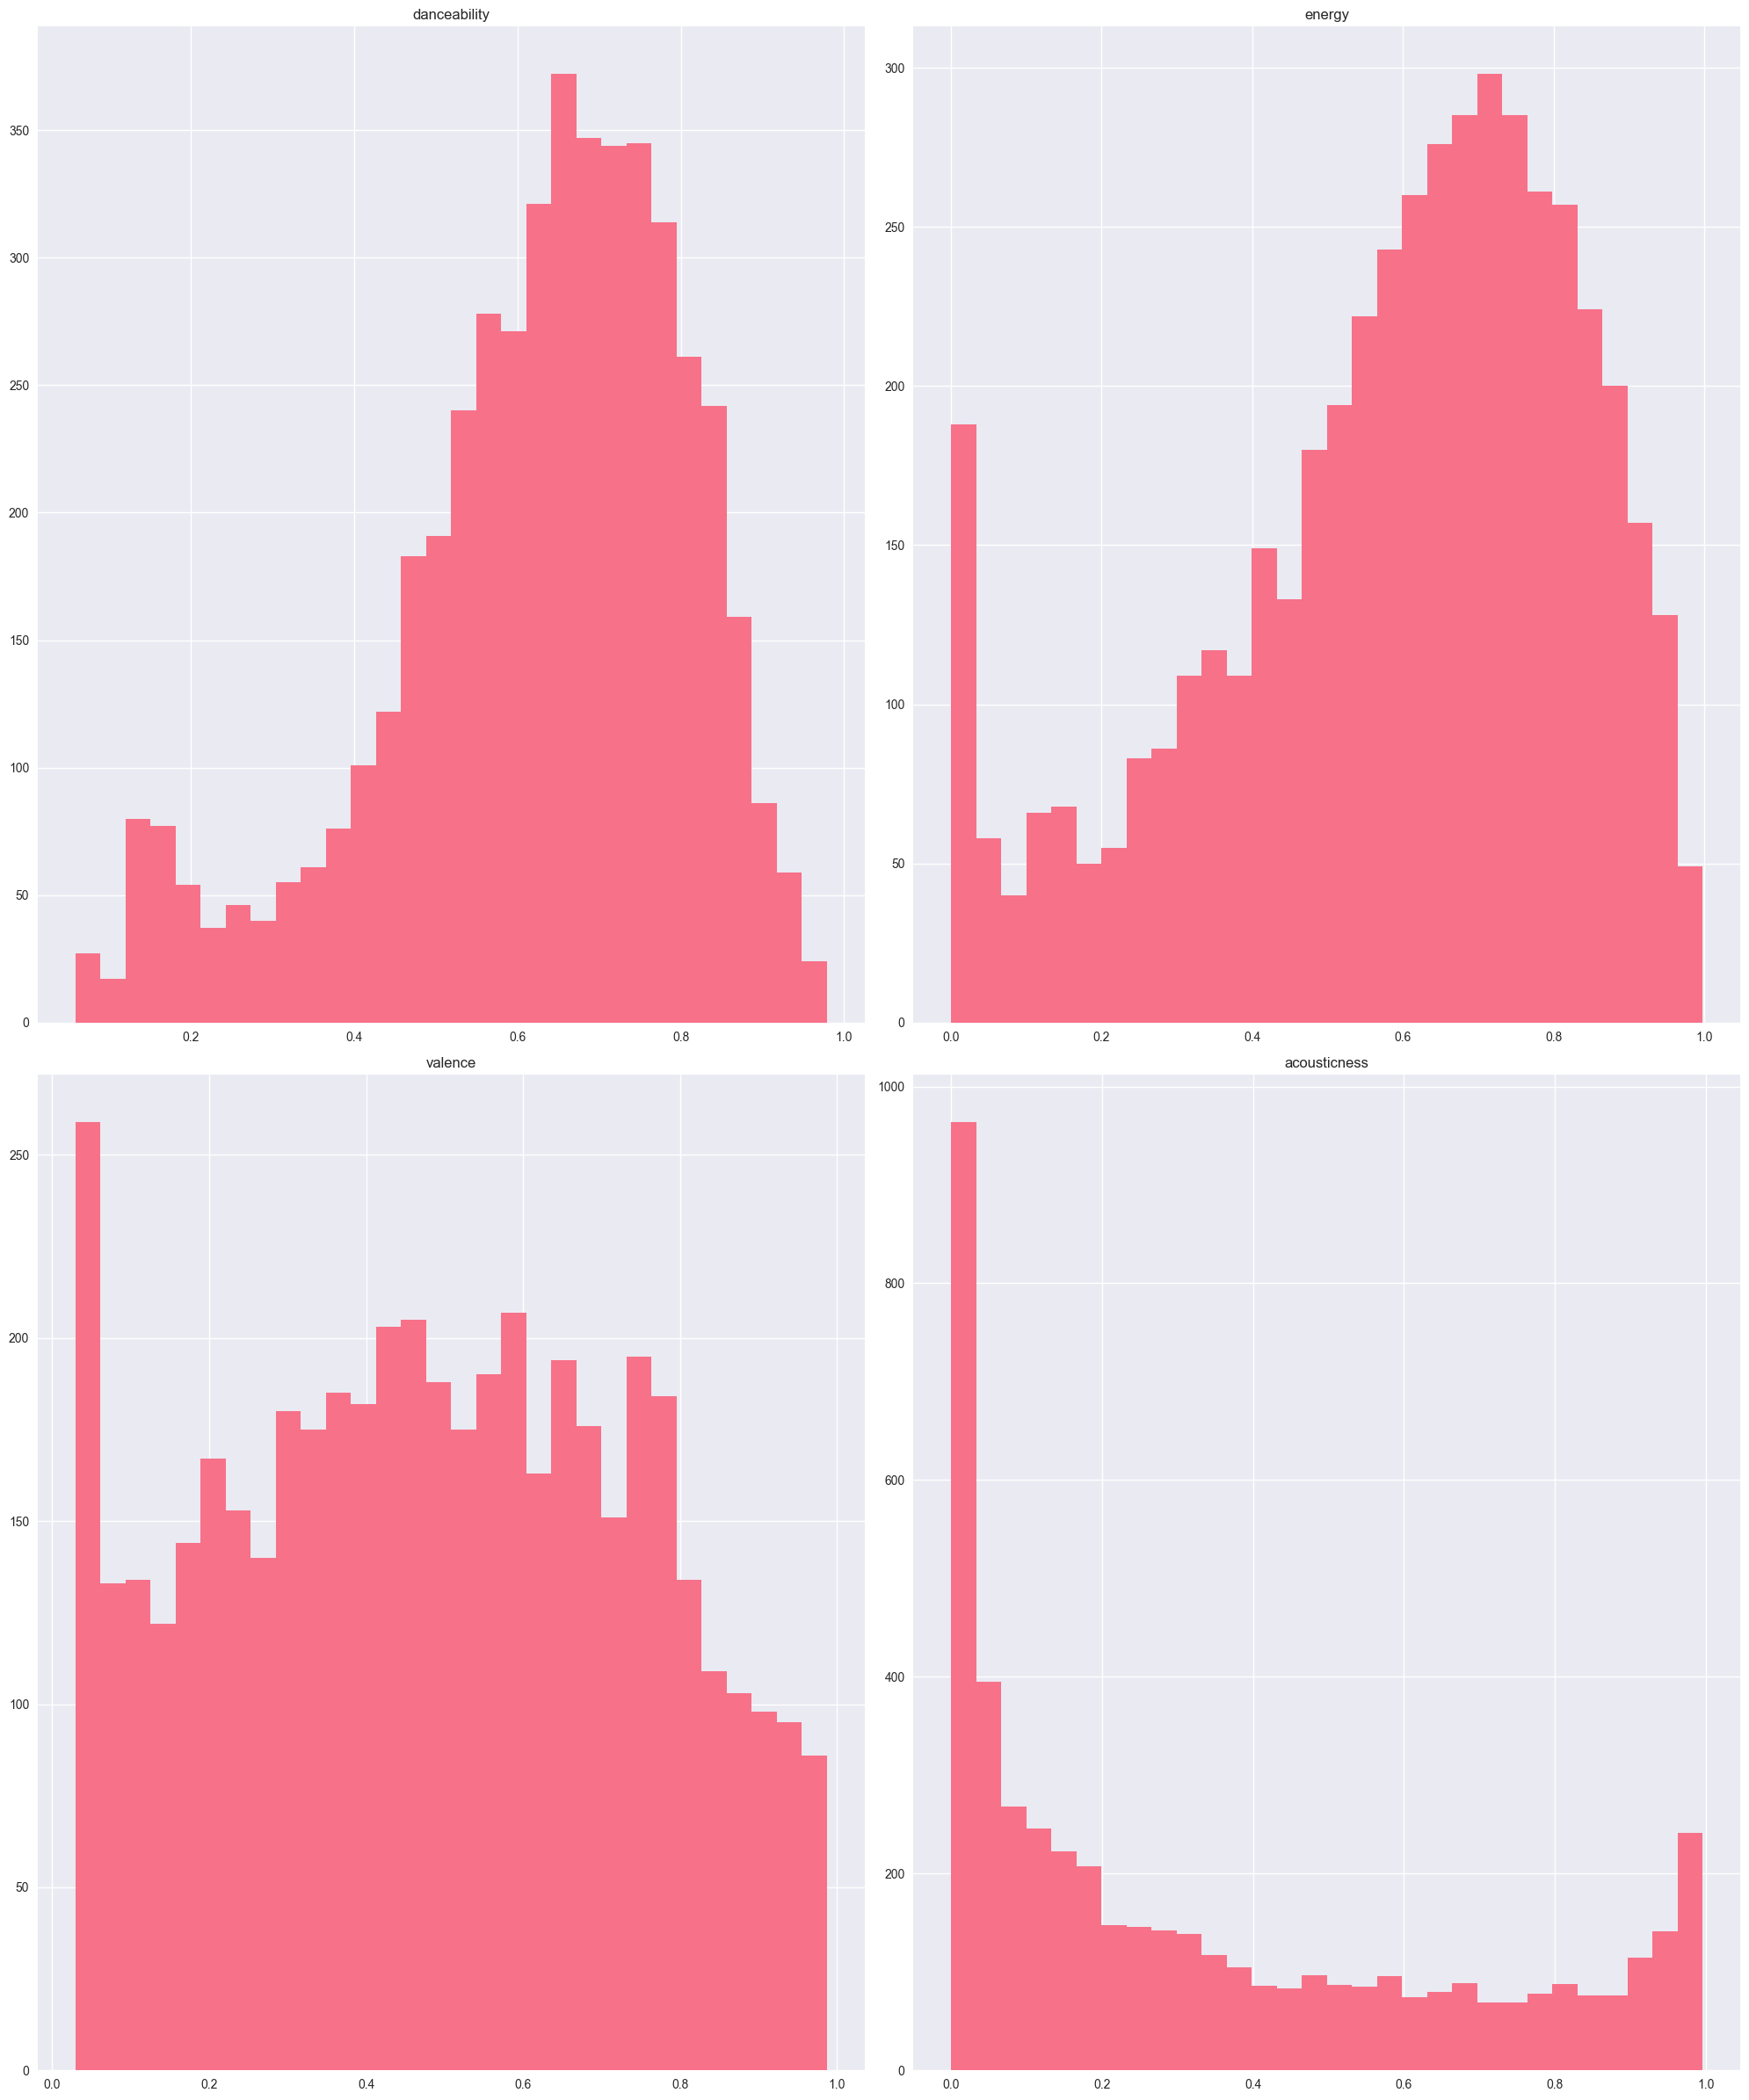

In [25]:
# Set up the plotting
fig, axes = plt.subplots(4, 3, figsize=(20, 24))
fig.suptitle('Spotify Dataset - Comprehensive EDA', fontsize=20, fontweight='bold')

# 2. Distribution of target variable
if 'track_popularity' in df.columns:
    sns.histplot(data=df, x='track_popularity', bins=30, kde=True, ax=axes[0,1])
    axes[0,1].set_title('Track Popularity Distribution')

# 3. Genre distribution
if 'playlist_genre' in df.columns:
    genre_counts = df['playlist_genre'].value_counts()
    sns.barplot(x=genre_counts.values, y=genre_counts.index, ax=axes[0,2])
    axes[0,2].set_title('Genre Distribution')

# 4. Energy vs Valence scatter
if all(col in df.columns for col in ['energy', 'valence', 'playlist_genre']):
    sns.scatterplot(data=df.sample(1000), x='energy', y='valence',
                   hue='playlist_genre', alpha=0.7, ax=axes[1,0])
    axes[1,0].set_title('Energy vs Valence by Genre')

# 5. Popularity by genre boxplot
if all(col in df.columns for col in ['playlist_genre', 'track_popularity']):
    sns.boxplot(data=df, x='playlist_genre', y='track_popularity', ax=axes[1,1])
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].set_title('Popularity by Genre')

# 6. Audio features distribution
audio_features_subset = ['danceability', 'energy', 'valence', 'acousticness']
df[audio_features_subset].hist(bins=30, ax=axes[1,2], layout=(2,2))
axes[1,2].set_title('Audio Features Distribution')

# 7. Tempo distribution
if 'tempo' in df.columns:
    sns.histplot(data=df, x='tempo', bins=50, kde=True, ax=axes[2,0])
    axes[2,0].set_title('Tempo Distribution')

# 8. Duration analysis
if 'duration_ms' in df.columns:
    df['duration_minutes'] = df['duration_ms'] / 60000
    sns.histplot(data=df, x='duration_minutes', bins=50, kde=True, ax=axes[2,1])
    axes[2,1].set_title('Song Duration Distribution')
    axes[2,1].set_xlim(0, 10)  # Focus on reasonable durations

# 9. Yearly trends
if 'release_year' in df.columns:
    yearly_popularity = df.groupby('release_year')['track_popularity'].mean()
    yearly_popularity.plot(ax=axes[2,2])
    axes[2,2].set_title('Average Popularity by Release Year')
    axes[2,2].set_xlabel('Release Year')

# 10. Loudness vs Energy
if all(col in df.columns for col in ['loudness', 'energy']):
    sns.scatterplot(data=df.sample(1000), x='loudness', y='energy',
                   alpha=0.6, ax=axes[3,0])
    axes[3,0].set_title('Loudness vs Energy')

# 11. Speechiness vs Instrumentalness
if all(col in df.columns for col in ['speechiness', 'instrumentalness']):
    sns.scatterplot(data=df.sample(1000), x='speechiness', y='instrumentalness',
                   alpha=0.6, ax=axes[3,1])
    axes[3,1].set_title('Speechiness vs Instrumentalness')

# 12. Mode distribution
if 'mode' in df.columns:
    mode_counts = df['mode'].value_counts()
    sns.barplot(x=mode_counts.index, y=mode_counts.values, ax=axes[3,2])
    axes[3,2].set_title('Mode Distribution (0=Minor, 1=Major)')

plt.tight_layout()
plt.show()


## Feature Importance Analysis

In [26]:
if 'track_popularity' in df.columns:
    # Correlation with target
    target_corr = df[audio_features + ['track_popularity']].corr()['track_popularity'].abs().sort_values(ascending=False)
    print("Feature correlation with popularity:")
    print(target_corr.drop('track_popularity'))

Feature correlation with popularity:
instrumentalness    0.263147
acousticness        0.232679
loudness            0.217100
energy              0.194709
danceability        0.128388
valence             0.096816
tempo               0.059866
key                 0.029174
liveness            0.022258
duration_ms         0.021463
speechiness         0.019250
time_signature      0.003242
mode                0.003091
Name: track_popularity, dtype: float64


## Preferred Columns for Feature Selection

In [37]:
print("FEATURES TO KEEP:")
print("=" * 30)

keep_features = []
drop_features = []

# Audio features (core predictive features)
audio_core = ['energy', 'danceability', 'valence', 'acousticness',
              'instrumentalness', 'speechiness', 'liveness', 'loudness', 'tempo']
keep_features.extend(audio_core)
print(f"Audio Features: {audio_core}")

# Target variable
if 'track_popularity' in df.columns:
    keep_features.append('track_popularity')
    print("Target: track_popularity")

# Important categorical
categorical_keep = ['playlist_genre', 'playlist_subgenre']
keep_features.extend(categorical_keep)
print(f"Categorical: {categorical_keep}")

# Temporal
if 'track_album_release_date' in df.columns:
    keep_features.append('track_album_release_date')
    print("Temporal: track_album_release_date")

# Duration
if 'duration_ms' in df.columns:
    keep_features.append('duration_ms')
    print("Duration: duration_ms")

print("FEATURES TO DROP:")
print("=" * 25)

# Identifier columns (high cardinality, no predictive value)
identifiers = ['track_id', 'track_href', 'uri', 'analysis_url', 'id',
               'track_album_id', 'playlist_id', 'type']
drop_features.extend(identifiers)
print(f" Identifiers: {identifiers}")

# Redundant text columns
text_redundant = ['track_name', 'track_artist', 'track_album_name', 'playlist_name']
drop_features.extend(text_redundant)
print(f" Text/Names: {text_redundant}")

# Low variance or redundant features
if 'mode' in df.columns and df['mode'].nunique() <= 2:
    drop_features.append('mode')
    print(" Low variance: mode")

if 'time_signature' in df.columns and df['time_signature'].nunique() <= 3:
    drop_features.append('time_signature')
    print(" Low variance: time_signature")

if 'key' in df.columns:
    drop_features.append('key')
    print(" Musical key (likely low predictive power)")

# Popularity label if it's derived from track_popularity
if 'popularity_label' in df.columns:
    drop_features.append('popularity_label')
    print(" Derived feature: popularity_label")

print(f"SUMMARY:")
print(f"Keep: {len(keep_features)} features")
print(f"Drop: {len(drop_features)} features")
print(f"Original: {df.shape[1]} features")
print(f"Reduced: {len(keep_features)} features")

# print("\n# Create cleaned dataset")
# print("df_clean = df[keep_features].copy()")
# print("\n# Handle missing values")
# print("df_clean = df_clean.dropna()")
print(f"Final dataset shape: {df[keep_features].dropna().shape}")


FEATURES TO KEEP:
Audio Features: ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'speechiness', 'liveness', 'loudness', 'tempo']
Target: track_popularity
Categorical: ['playlist_genre', 'playlist_subgenre']
Temporal: track_album_release_date
Duration: duration_ms
FEATURES TO DROP:
 Identifiers: ['track_id', 'track_href', 'uri', 'analysis_url', 'id', 'track_album_id', 'playlist_id', 'type']
 Text/Names: ['track_name', 'track_artist', 'track_album_name', 'playlist_name']
 Low variance: mode
 Musical key (likely low predictive power)
 Derived feature: popularity_label
SUMMARY:
Keep: 14 features
Drop: 15 features
Original: 36 features
Reduced: 14 features
Final dataset shape: (4830, 14)


## Feature Engineering based on EDA

In [38]:
def feature_engineering(df):
    df_fe = df.copy()

    # Extract year from release date
    df_fe['track_album_release_date'] = pd.to_datetime(df_fe['track_album_release_date'], errors='coerce')
    df_fe['release_year'] = df_fe['track_album_release_date'].dt.year
    df_fe['release_decade'] = (df_fe['release_year'] // 10) * 10

    # Calculate age of track (current year - release year)
    current_year = datetime.now().year
    df_fe['track_age'] = current_year - df_fe['release_year']

    # Duration in minutes
    df_fe['duration_minutes'] = df_fe['duration_ms'] / 60000

    # Create duration categories
    df_fe['duration_category'] = pd.cut(df_fe['duration_minutes'],
                                       bins=[0, 2.5, 3.5, 4.5, float('inf')],
                                       labels=['Short', 'Medium', 'Long', 'Very_Long'])

    # Audio feature combinations (based on music theory)
    df_fe['energy_valence'] = df_fe['energy'] * df_fe['valence']
    df_fe['acoustic_instrumental'] = df_fe['acousticness'] * df_fe['instrumentalness']
    df_fe['danceability_energy'] = df_fe['danceability'] * df_fe['energy']
    df_fe['mood_score'] = (df_fe['energy'] + df_fe['valence'] + df_fe['danceability']) / 3

    # Loudness categories (typical ranges)
    df_fe['loudness_category'] = pd.cut(df_fe['loudness'],
                                       bins=[-float('inf'), -10, -5, 0, float('inf')],
                                       labels=['Quiet', 'Medium', 'Loud', 'Very_Loud'])

    # Tempo categories (BPM ranges)
    df_fe['tempo_category'] = pd.cut(df_fe['tempo'],
                                    bins=[0, 90, 120, 140, 180, float('inf')],
                                    labels=['Slow', 'Medium', 'Upbeat', 'Fast', 'Very_Fast'])

    # Audio complexity score
    df_fe['audio_complexity'] = (df_fe['speechiness'] + df_fe['instrumentalness'] +
                                df_fe['acousticness'] + df_fe['liveness']) / 4

    # Mainstream score (inverse of complexity + high danceability/energy)
    df_fe['mainstream_score'] = (df_fe['danceability'] + df_fe['energy'] + df_fe['valence'] -
                                df_fe['audio_complexity']) / 3

    print(" Feature engineering completed!")
    print(f"   - Original features: {df.shape[1]}")
    print(f"   - New features added: {df_fe.shape[1] - df.shape[1]}")

    return df_fe

# Apply feature engineering
df_engineered = feature_engineering(df)

 Feature engineering completed!
   - Original features: 36
   - New features added: 8


## Handling Missing values

In [40]:
def handle_missing_values(df):
    df_clean = df.copy()

    print("Missing values before cleaning:")
    missing_before = df_clean.isnull().sum()
    print(missing_before[missing_before > 0])

    # For numerical features - use median imputation as better dealing with outliers
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"Filled {col} with median: {median_val}")

    # For categorical features - use mode imputation as it is good to use with categorial values
    categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            mode_val = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_val, inplace=True)
            print(f"Filled {col} with mode: {mode_val}")

    print(f"Missing values handled! Remaining nulls: {df_clean.isnull().sum().sum()}")
    return df_clean

df_clean = handle_missing_values(df_engineered)


Missing values before cleaning:
energy                        1
tempo                         1
danceability                  1
loudness                      1
liveness                      1
valence                       1
time_signature                1
speechiness                   1
track_href                    1
uri                           1
track_album_name              1
analysis_url                  1
track_album_release_date    138
instrumentalness              1
mode                          1
key                           1
duration_ms                   1
acousticness                  1
id                            1
type                          1
release_year                138
duration_minutes              1
duration_category             1
mood_score                    1
acoustic_instrumental         1
release_decade              138
track_age                   138
energy_valence                1
danceability_energy           1
loudness_category             1
tempo_ca

## Defining Finalized Columns for Model Training

In [42]:
# Define feature categories
AUDIO_FEATURES = [
    'energy', 'danceability', 'valence', 'acousticness', 'instrumentalness',
    'speechiness', 'liveness', 'loudness', 'tempo'
]

ENGINEERED_FEATURES = [
    'energy_valence', 'danceability_energy', 'mood_score', 'mainstream_score',
    'audio_complexity', 'duration_minutes', 'track_age'
]

CATEGORICAL_FEATURES = [
    'playlist_genre', 'playlist_subgenre', 'duration_category',
    'loudness_category', 'tempo_category'
]

TARGET = 'track_popularity'

# Select features for modeling
selected_features = AUDIO_FEATURES + ENGINEERED_FEATURES + CATEGORICAL_FEATURES
X = df_clean[selected_features].copy()
y = df_clean[TARGET].copy()

print(f"Selected features ({len(selected_features)}):")
print(f"Audio features: {len(AUDIO_FEATURES)}")
print(f"Engineered features: {len(ENGINEERED_FEATURES)}")
print(f"Categorical features: {len(CATEGORICAL_FEATURES)}")
print(f"Target: {TARGET}")


Selected features (21):
Audio features: 9
Engineered features: 7
Categorical features: 5
Target: track_popularity


## TRAIN TEST SPLIT

In [44]:
numerical_features = AUDIO_FEATURES + ENGINEERED_FEATURES
categorical_features = CATEGORICAL_FEATURES

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

print("Doing TRAIN-TEST SPLIT")
# Remove rows with missing target
valid_idx = y.notna()
X = X[valid_idx]
y = y[valid_idx]

print(f"Dataset shape after removing missing targets: {X.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=5)
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Numerical features: ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'speechiness', 'liveness', 'loudness', 'tempo', 'energy_valence', 'danceability_energy', 'mood_score', 'mainstream_score', 'audio_complexity', 'duration_minutes', 'track_age']
Categorical features: ['playlist_genre', 'playlist_subgenre', 'duration_category', 'loudness_category', 'tempo_category']
Doing TRAIN-TEST SPLIT
Dataset shape after removing missing targets: (4831, 21)
Training set: (3864, 21)
Test set: (967, 21)


## Normalizing Data

In [45]:
# Handle numerical features
X_train_num = X_train[numerical_features].fillna(X_train[numerical_features].median())
X_test_num = X_test[numerical_features].fillna(X_train[numerical_features].median())

# Standardize numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Handle categorical features with one-hot encoding
X_train_cat = X_train[categorical_features].fillna(X_train[categorical_features].mode().iloc[0])
X_test_cat = X_test[categorical_features].fillna(X_train[categorical_features].mode().iloc[0])

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Combine numerical and categorical features
X_train_processed = np.hstack([X_train_num_scaled, X_train_cat_encoded])
X_test_processed = np.hstack([X_test_num_scaled, X_test_cat_encoded])

print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")

Processed training set shape: (3864, 143)
Processed test set shape: (967, 143)


## Model 1: Random Forrest Regressor





In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Train the model
rf_model.fit(X_train_processed, y_train)
# Making predictions
y_train_pred = rf_model.predict(X_train_processed)
y_test_pred = rf_model.predict(X_test_processed)

#Metrics
rf_metrics = {
    'Train_R2': r2_score(y_train, y_train_pred),
    'Test_R2': r2_score(y_test, y_test_pred),
    'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'Train_MAE': mean_absolute_error(y_train, y_train_pred),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred),
}

#cross validation
cv_scores = cross_val_score(rf_model, X_train_processed, y_train, cv=5, scoring='r2')
rf_metrics['CV_R2_Mean'] = cv_scores.mean()
rf_metrics['CV_R2_Std'] = cv_scores.std()

#metrics print
for metric, value in rf_metrics.items():
    print(f"{metric}: {value}")

# Store results for later comparison
rf_results = rf_metrics
rf_predictions = y_test_pred

Train_R2: 0.9496
Test_R2: 0.6601
Train_RMSE: 4.4557
Test_RMSE: 11.5208
Train_MAE: 3.2304
Test_MAE: 8.4325
CV_R2_Mean: 0.6311
CV_R2_Std: 0.0165


### Model 2: Linear Regression

In [ ]:
lr_model = LinearRegression()
# Train the model
lr_model.fit(X_train_processed, y_train)
# Making predictions
y_train_pred = lr_model.predict(X_train_processed)
y_test_pred = lr_model.predict(X_test_processed)

#Metrics
lr_metrics = {
    'Train_R2': r2_score(y_train, y_train_pred),
    'Test_R2': r2_score(y_test, y_test_pred),
    'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'Train_MAE': mean_absolute_error(y_train, y_train_pred),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred),
}

#cross validation
cv_scores = cross_val_score(lr_model, X_train_processed, y_train, cv=5, scoring='r2')
lr_metrics['CV_R2_Mean'] = cv_scores.mean()
lr_metrics['CV_R2_Std'] = cv_scores.std()

#metrics print
for metric, value in lr_metrics.items():
    print(f"{metric}: {value}")

# Store results for later comparison
lr_results = lr_metrics
lr_predictions = y_test_pred

Train_R2: 0.6702
Test_R2: 0.6548
Train_RMSE: 11.3959
Test_RMSE: 11.6102
Train_MAE: 8.0844
Test_MAE: 8.3723
CV_R2_Mean: 0.6473
CV_R2_Std: 0.0129


## Model 3: Ridge Regressor

In [ ]:
ridge_model = Ridge(random_state=42)
# Train the model
ridge_model.fit(X_train_processed, y_train)
# Making predictions
y_train_pred = ridge_model.predict(X_train_processed)
y_test_pred = ridge_model.predict(X_test_processed)

#Metrics
ridge_metrics = {
    'Train_R2': r2_score(y_train, y_train_pred),
    'Test_R2': r2_score(y_test, y_test_pred),
    'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'Train_MAE': mean_absolute_error(y_train, y_train_pred),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred),
}

#cross validation
cv_scores = cross_val_score(lr_model, X_train_processed, y_train, cv=5, scoring='r2')
ridge_metrics['CV_R2_Mean'] = cv_scores.mean()
ridge_metrics['CV_R2_Std'] = cv_scores.std()

#metrics print
for metric, value in ridge_metrics.items():
    print(f"{metric}: {value}")

# Store results for later comparison
ridge_results = ridge_metrics
ridge_predictions = y_test_pred

Train_R2: 0.6617
Test_R2: 0.6438
Train_RMSE: 11.5410
Test_RMSE: 11.7946
Train_MAE: 8.2739
Test_MAE: 8.5615
CV_R2_Mean: 0.6473
CV_R2_Std: 0.0129


## Model Comparison Visualization

CREATING VISUALIZATIONS
--------------------------------------------------
Best model: Random Forest (Test R²: 0.6601)


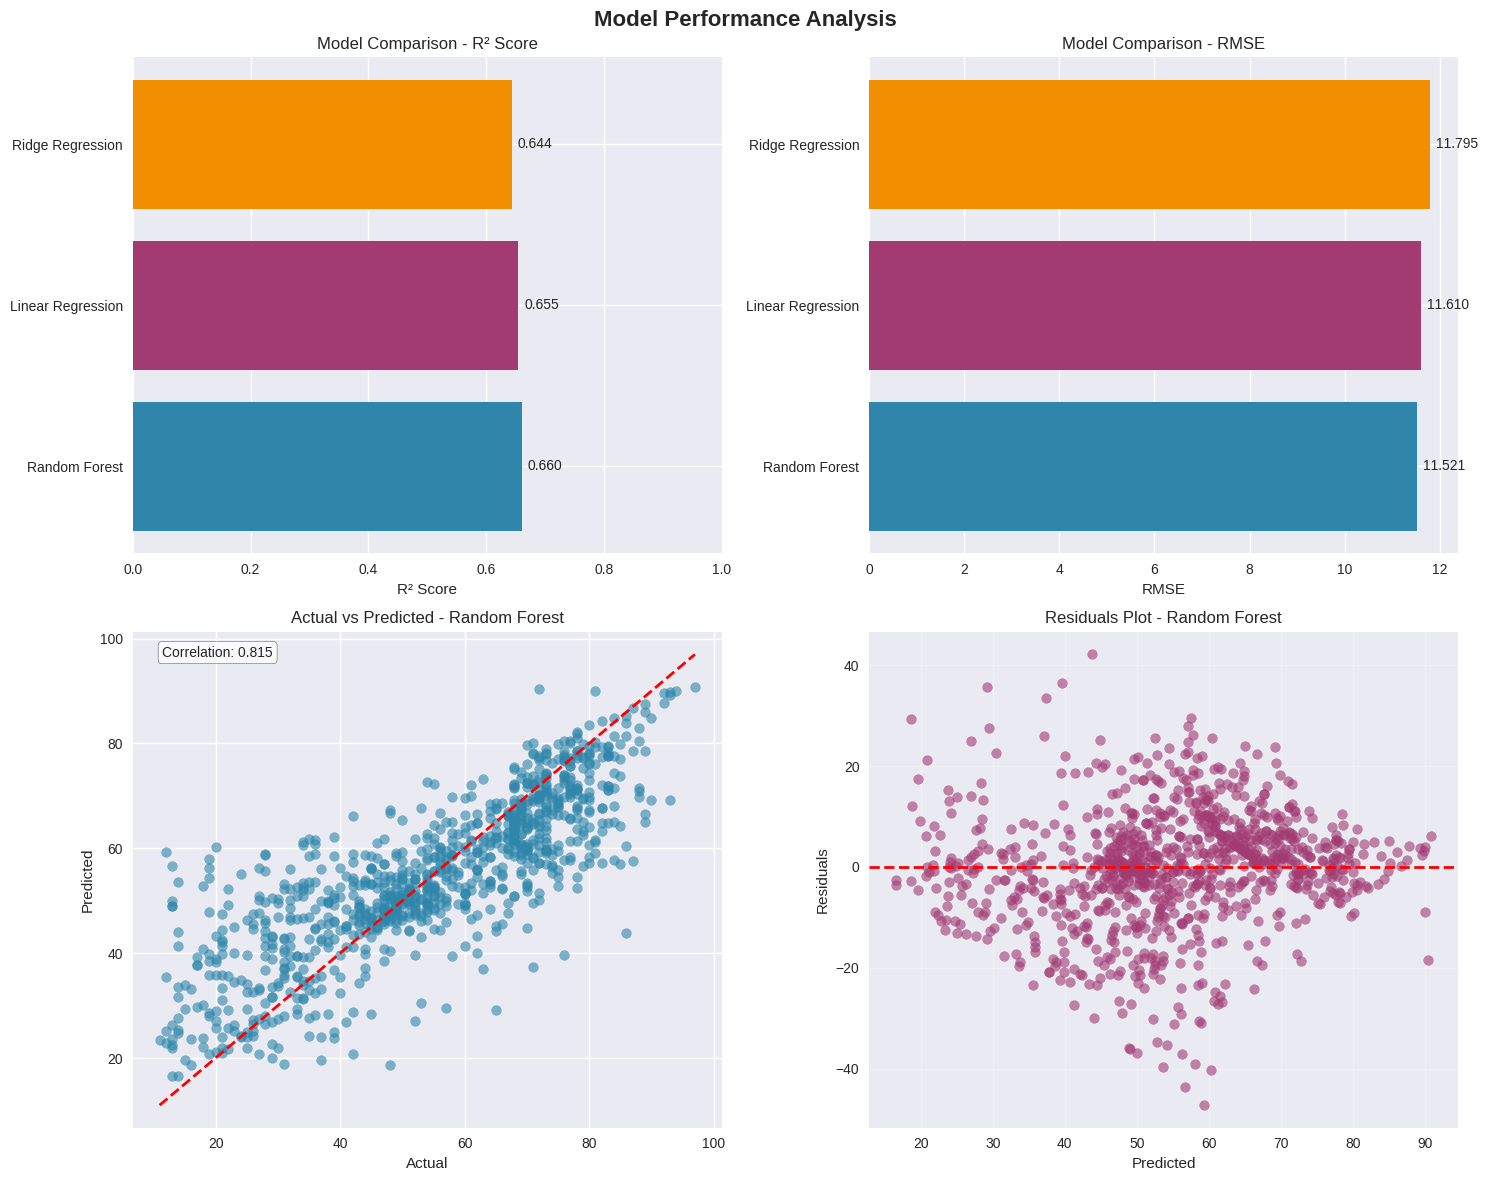

MODEL COMPARISON SUMMARY
--------------------------------------------------
Model                Test R²    Test RMSE    Test MAE    
------------------------------------------------------
Random Forest        0.6601     11.5208      8.4325      
Linear Regression    0.6548     11.6102      8.3723      
Ridge Regression     0.6438     11.7946      8.5615      
Best performing model: Random Forest
Test R²: 0.6601
Test RMSE: 11.5208
Cross-validation R²: 0.6311 (±0.0165)


In [ ]:
results = {
    'Random Forest': rf_results,
    'Linear Regression': lr_results,
    'Ridge Regression': ridge_results
}

predictions = {
    'Random Forest': rf_predictions,
    'Linear Regression': lr_predictions,
    'Ridge Regression': ridge_predictions
}

# Find the best model based on Test R²
best_model_name = max(results.keys(), key=lambda x: results[x]['Test_R2'])
print(f"Best model: {best_model_name} (Test R²: {results[best_model_name]['Test_R2']:.4f})")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Model comparison - R² Score
models_names = list(results.keys())
test_r2_scores = [results[name]['Test_R2'] for name in models_names]
test_rmse_scores = [results[name]['Test_RMSE'] for name in models_names]

bars1 = axes[0,0].barh(models_names, test_r2_scores, color=['#2E86AB', '#A23B72', '#F18F01'])
axes[0,0].set_xlabel('R² Score')
axes[0,0].set_title('Model Comparison - R² Score')
axes[0,0].set_xlim(0, 1)

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    axes[0,0].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', ha='left', va='center', fontsize=10)

# 2. RMSE comparison
bars2 = axes[0,1].barh(models_names, test_rmse_scores, color=['#2E86AB', '#A23B72', '#F18F01'])
axes[0,1].set_xlabel('RMSE')
axes[0,1].set_title('Model Comparison - RMSE')

# Add value labels on bars
for i, bar in enumerate(bars2):
    width = bar.get_width()
    axes[0,1].text(width + max(test_rmse_scores) * 0.01, bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', ha='left', va='center', fontsize=10)

# 3. Actual vs Predicted (best model)
best_predictions = predictions[best_model_name]
axes[1,0].scatter(y_test, best_predictions, alpha=0.6, color='#2E86AB')
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual')
axes[1,0].set_ylabel('Predicted')
axes[1,0].set_title(f'Actual vs Predicted - {best_model_name}')

# Add correlation coefficient
corr_coef = np.corrcoef(y_test, best_predictions)[0, 1]
axes[1,0].text(0.05, 0.95, f'Correlation: {corr_coef:.3f}',
               transform=axes[1,0].transAxes, fontsize=10,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Residuals plot
residuals = y_test - best_predictions
axes[1,1].scatter(best_predictions, residuals, alpha=0.6, color='#A23B72')
axes[1,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title(f'Residuals Plot - {best_model_name}')

# Add grid to residuals plot
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("MODEL COMPARISON SUMMARY")
print("-" * 50)
print(f"{'Model':<20} {'Test R²':<10} {'Test RMSE':<12} {'Test MAE':<12}")
print("-" * 54)
for name in models_names:
    print(f"{name:<20} {results[name]['Test_R2']:<10.4f} {results[name]['Test_RMSE']:<12.4f} {results[name]['Test_MAE']:<12.4f}")

print(f"Best performing model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['Test_R2']:.4f}")
print(f"Test RMSE: {results[best_model_name]['Test_RMSE']:.4f}")
print(f"Cross-validation R²: {results[best_model_name]['CV_R2_Mean']:.4f} (±{results[best_model_name]['CV_R2_Std']:.4f})")

## Save Model files

In [ ]:
joblib.dump(ridge_model, f'ridge_model.pkl')

feature_info = {
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'all_features': selected_features,
    'target': TARGET,
    'model_name': 'Ridge Regression',
    'model_metrics': ridge_metrics
}
with open("ridge_feature_info.pkl", 'wb') as f:
    pickle.dump(feature_info, f)

print("Ridge model saved and info saved")

Ridge model saved and info saved


In [ ]:
joblib.dump(lr_model, f'linear_model.pkl')

feature_info = {
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'all_features': selected_features,
    'target': TARGET,
    'model_name': 'Linear Regression',
    'model_metrics': lr_metrics
}

with open('linear_feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)


print("Linear model saved and info saved")

Linear model saved and info saved


In [ ]:
joblib.dump(rf_model, f'rf_model.pkl')

feature_info = {
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'all_features': selected_features,
    'target': TARGET,
    'model_name': 'Random Forrest Regressor',
    'model_metrics': rf_metrics
}

with open('rf_feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)


print("Random Forrest model saved and info saved")

Random Forrest model saved and info saved


In [ ]:
encoder_mapping = {'playlist_genre': ['afrobeats', 'ambient', 'arabic', 'blues', 'brazilian', 'cantopop', 'classical', 'country', 'disco', 'electronic', 'folk', 'funk', 'gaming', 'gospel', 'hip-hop', 'indian', 'indie', 'j-pop', 'jazz', 'k-pop', 'korean', 'latin', 'lofi', 'mandopop', 'metal', 'pop', 'punk', 'r&b', 'reggae', 'rock', 'soca', 'soul', 'turkish', 'wellness', 'world'],
 'playlist_subgenre': ['80s', '90s', 'academic', 'african', 'afro house', 'afro-latin', 'alternative', 'amapiano', 'american', 'anime', 'australian', 'avant-garde', 'bedroom', 'bhangra', 'bollywood', 'cajun', 'carnival', 'celtic', 'chill', 'chinese', 'choral', 'cinematic', 'classic', 'classical', 'cumbia', 'death', 'deep house', 'delta', 'desi', 'drama', 'drill', 'essential', 'experimental', 'feel-good', 'forró', 'french', 'funk', 'fusion', 'future', 'future bass', 'gangster', 'global', 'gqom', 'grime', 'hardstyle', 'heavy', 'hip-hop', 'indie', 'indigenous', 'irish', 'italo', 'japanese', 'jewish', 'klezmer', 'latin', 'mainstream', 'meditative', 'melodic', 'modern', 'neo-classical', 'nigerian', 'noir', 'nordic', 'pop', 'pop punk', 'post-rock', 'reggaeton', 'retro', 'samba', 'scandi', 'smooth', 'soft', 'soundtracks', 'southern', 'spanish', 'tango', 'techno', 'throat singing', 'throwback', 'trap', 'tropical', 'vaporwave', 'workout', 'yoga'],
 'duration_category': ['Long', 'Medium', 'Short', 'Very_Long'], 'loudness_category': ['Loud', 'Medium', 'Quiet', 'Very_Loud'],
 'tempo_category': ['Fast', 'Medium', 'Slow', 'Upbeat', 'Very_Fast']}

with open('categorical_mappings.pkl', 'wb') as f:
    pickle.dump(encoder_mapping, f)

In [46]:
scaler_path = os.path.join('ridge_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"scaler saved: {scaler_path}")

encoder_path = os.path.join('ridge_encoder.pkl')
joblib.dump(encoder, encoder_path)
print(f"encoder saved: {encoder_path}")

scaler saved: ridge_scaler.pkl
encoder saved: ridge_encoder.pkl
